# Axegine Optimal B/A Pricing Model  - ajl

## Problem (re) statement and analysis

We are making markets in a single risky asset having a lognormal price process
$$
dP_t = P_t\left( \mu\,dt + \sigma\,dW_t\right).
$$

Buy and sell orders are modeled as a Poisson counting process with densities $\lambda_0^b$ and $\lambda_0^s$. Our quotes take the form
$$
P_te^{\pm s_t}
$$
and the probability the quote is accepted is modeled as
$$
\lambda_1^\cdot(s_t) = e^{-\beta s^\cdot_t}.
$$
Note $\beta$ is a parameter reflecting the fact that we cannot guarantee winning the trade by setting the spread to zero:
$$
P(\text{agent}\,\text{buys}\,\vert\, s\in[0,\delta)) = \int_0^\delta e^{-\beta s}\,ds=1-\frac 1\beta e^{-\beta\delta} \approx 1 - \frac 1\beta +\delta.
$$
Obviously we must have $\beta\geq 1$, and really only $\beta > 1$ is realistic, as other dealers may be better buyers and sellers (perhaps using a different utility function than us).

_**Claim**: Accepted trades arrive at rate $\lambda^\cdot = \lambda_0^\cdot \times \lambda_1^\cdot.$_ (TODO)

Trade quantities are denoted by $Q$. In this setup the change in inventory is goverened by
$$
dI_t = \left(Q^s\lambda^s - Q^b\lambda^b\right)\,dt
$$
In words, the difference between expected agent sells (our buys) and expected agent buys (our sells) over a small time period.

The change in our cash account is similar, except that we have to reflect the transaction prices:
$$
dC_t = P_t\left(Q^b\lambda^b e^{s^A} - Q^s\lambda^s e^{-s^B} \right)\,dt
$$
As a mental check, if we take $Q=1$ and $s=s^A=s^B$ and $\lambda = \lambda^b = \lambda^a$ we have
$$
dC_t = Q\lambda P_t\left(e^s - e^{-s}\right)\,dt\approx 2 Q\lambda P_t s\,dt
$$
which is twice the ("proportional") spread times the expected quantity traded. (I.e. the spread convention here is a percentage of value, not the more usual absolute amount.)

Our wealth process is simply the sum of the cash account and value of our position (taken at mid):
$$
\Pi_t = C_t + I_t P_t,
$$
and we are asked to choose a policy $\left\{s^A_t, s^B_t\right\}$ that maximizes exponential utility at some terminal time $T$:
$$
   \max {\bf E}\left[-e^{-\Pi(T)}\right]
$$

### Observations

* No time value of money (risk-free rate is zero).
* Can borrow indefinitely, implying no upper limit on long position
* Can short indefinitely
* No penalty for holding inventory; no link between spreads and inventory
* No explicity hedging of position, although $P_t$ could reprsent the price dynamics of a hedged portfolio
* Might re-parameterize to the arrival rate of unit orders - i.e. collapse $Q$ and $\lambda$.

### Overall solution strategy

* Simulate to check understanding and validate expected sensitivites, such as 
  * Don't really see any time-dependence here
  * Similarly the policy won't depend on position, 
  * So perhaps it doesn't depend on wealth, and it's a constant 
  * Bid and ask spreads won't be symmetric - the asymmetry should be controlled by $\mu$ and the relative arrival rates of buy and sell orders (and relative buy and sell sizes).
  * Bid and ask spreads increase with $\sigma$
* Write down the SDE for the wealth process
* Find the infinitessimal generator and pose the optimization as an HJB equation
* Assume a classical solution and "differentiate" to find the optimal policy
* Analyze the PDE more to see what we can say about expected terinal wealth

## Simulation

In [1]:
import numpy as np
import matplotlib.pylab as plt

In [2]:
class AxSim(object):
    def __init__(self, P0, T, dt, mu, sig, lam0b, lam0s, beta, ns):
        self.P0 = P0
        self.T = T
        self.dt = dt
        self.mu = mu
        self.sig = sig
        self.lam0b = lam0b
        self.lam0s = lam0s
        self.beta = beta
        self.ns = ns                
        self.Qb = 1.0        
        self.Qs = 1.0
        
    def run_sim(self, sA, sB, prt_out):
        Pt = np.zeros((self.T+1, self.ns))
        Ct = np.zeros((self.T+1, self.ns))
        It = np.zeros((self.T+1, self.ns))
        Vt = np.zeros((self.T+1, self.ns))
        Pt[0,:] = self.P0
        ba_t = np.zeros((self.T+1, self.ns)) # buy arrivals
        sa_t = np.zeros((self.T+1, self.ns))
        bw_t = np.zeros((self.T+1, self.ns)) # buy wins
        sw_t = np.zeros((self.T+1, self.ns))        
        for t in range(self.T):
            # price process
            Wt = np.random.normal(scale=np.sqrt(self.dt), size=self.ns)
            X = np.exp((self.mu-0.5*self.sig**2)*self.dt) * np.exp(self.sig*Wt)
            Pt[t+1,:] = Pt[t,:] * X
            # order arrivals
            ba_t[t+1,:] = np.random.poisson(self.lam0b/12, self.ns) 
            sa_t[t+1,:] = np.random.poisson(self.lam0b/12, self.ns) 
            # prob our quote wins
            pb, pa = np.exp(-self.beta*sA), np.exp(-self.beta*sB)
            bw_t[t+1,:] = self.Qb*ba_t[t+1,:]*np.random.binomial(1, pb, size=self.ns)
            sw_t[t+1,:] = self.Qs*sa_t[t+1,:]*np.random.binomial(1, pa, size=self.ns)
            It[t+1,:] = It[t,:] + (sw_t[t+1,:] - bw_t[t+1,:]) # cust sells - cust buys
            Ct[t+1,:] = Ct[t,:] + Pt[t,:]*(bw_t[t+1,:]*np.exp(sA) 
                                           - sw_t[t+1,:]*np.exp(-sB)) 
            Vt[t+1,:] = Ct[t+1,:] + It[t+1,:]*Pt[t+1,:] # quote at P(t), mark at P(t+1)
        if prt_out:
            print('Bid arrivals per dt=%4.3f'%np.mean(np.mean(ba_t,axis=1)))
            print('Bids won per dt=%4.3f'%np.mean(np.mean(bw_t,axis=1)))
        return Vt, Ct, It

In [3]:
T = 250 # days
dt = 0.125 # 8 trading hours per day
Qs = 1.0 # unit customer sell size
Qb = 1.0 # unit customer buy size
mu = 0.02/250.0  # 2% per annum
sig = 0.01/np.sqrt(T) # 1% asset vol (eg high-quality bond)
lam0s = 0.6033*8.0 # 33% chance per dt via P(N(1/8)=1) = lam/8 exp(-lam/8) = 0.33
lam0b = lam0s # let's make buys and sells symmetric
beta = 8.0 # so we are only X% likely to win a trade with a zero spread
gam = 0.1
P0 = 100.0

In [4]:
sim1 = AxSim(P0, T, dt, mu, sig, lam0b, lam0s, 75.0, 1000)

Bid arrivals per dt=0.402
Bids won per dt=0.010
24.1616420068 12.5644752121 -0.167976113687


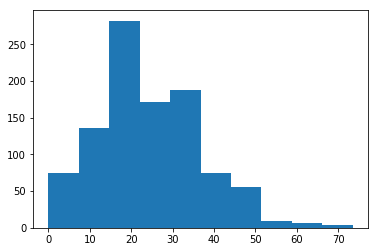

In [5]:
np.random.seed(123)
Vt, Ct, It = sim1.run_sim(0.05, 0.05, True)
UT = -np.exp(-gam*Vt[T,])
print(np.mean(Vt[T,]), np.std(Vt[T,]), np.mean(UT))
plt.hist(Vt[T,])
plt.show()

Bid arrivals per dt=0.402
Bids won per dt=0.191
95.2171678787 11.2405838467 -0.000132340272945


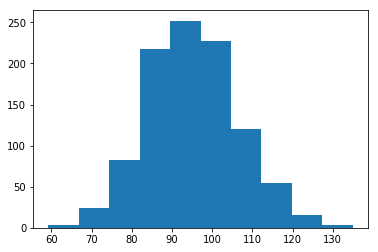

In [6]:
np.random.seed(123)
Vt, Ct, It = sim1.run_sim(0.01, 0.01, True)
UT = -np.exp(-gam*Vt[T,])
print(np.mean(Vt[T,]), np.std(Vt[T,]), np.mean(UT))
plt.hist(Vt[T,])
plt.show()

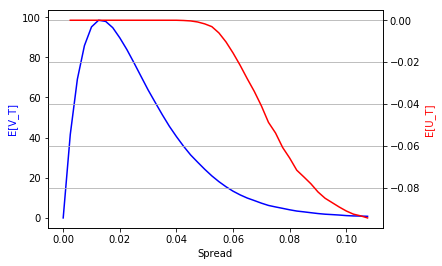

In [8]:
sj = np.arange(0.0, 0.11, 0.0025)
mv = np.zeros(np.shape(sj))
mu = np.zeros(np.shape(sj))
for j, s_j in enumerate(sj):
    np.random.seed(123)
    Vt, Ct, It = sim1.run_sim(s_j, s_j, False)
    mv[j] = np.mean(Vt[T,:])
    mu[j] = np.mean(-gam*np.exp(-Vt[T,:]))

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(sj, mv, 'b');
ax2.plot(sj[1:], mu[1:], 'r');
plt.grid(True);
ax1.set_xlabel('Spread');
ax1.set_ylabel('E[V_T]', color='b');
ax2.set_ylabel('E[U_T]', color='r');
plt.show();